# Энкодер-декодер архитектура
Сегодня мы рассмотрим такую важную архитектуру как энкодер-декодер.
В контексте обработки естественного языка эта архитекутра используется чаще всего в задачах преобразования последовательности в последовательность (seq2seq). Такие задачи включают, например, машинный перевод. 

Вопрос: Что еще бывает?

Рассмотрим общий вид таких моделей (здесь и далее иллюстрации из курса Лены Войты): 

![alt_text](../additional_materials/images/enc_dec-min.png)

Мы с вами до сих пор занимались рекуррентными сетями. Мы уже знаем, как модель работает в случае обычного моделирования языка. В случае энкодер-декодера в ней принципиально ничего не меняется - мы все еще будем генерировать предложения токен за токеном. Однако для формирования результата нам нужно уже что-то, описывающее вход. Энкодер-декодер в случае перевода имеет вид что=то вроде следующего:

![alt_text](../additional_materials/images/enc_dec_simple_rnn-min.png)

Идея довольно проста - давайте использовать последнее скрытое состояние закодированного входа как начальное для выхода. 
Вопрос: в чем минус такого решения?
Вопрос: а если у нас на входе не текст?


Мы опробуем наши модели кодировщика-декодера на проблеме понимания изображений. Эта задача, с одной стороны, заставляет нас использовать соответствующую архитектуру, с другой - позволяет опустить обучение энкодера, сосредоточившись только на декодере. 

Прежде чем мы перейдем к архитектуре, необходимо выполнить предварительную обработку. У нас есть две части нашей задачи - изображения и их описания. Для текстов нам необходимо применить токенизацию.

Однако, в отличие от прошлого раза, мы не будем применять простейшее представление текста. Наши строки данных содержат уникальные редкие слова. Если мы будем действовать на уровне слова, нам придется иметь дело с большим словарным запасом, мучаться с нормализацией и т.д. Если вместо этого использовать модели на уровне символов, то для обработки последовательности потребуется много итераций. На этот раз мы выберем что-нибудь среднее.

Один из популярных подходов называется кодированием Byte Pair (BPE). Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течении N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один символ, а редкие слова разбиваются на слоги или даже символы. С одной стороны, мы отнсительно эффективно составляем словарб, с другой стороны, если мы даже не будем знать новое слово, мы сможем побить его на символы и все равно закодировать.

Установим необходиме библиотеки:

In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install subword_nmt

Note: you may need to restart the kernel to use updated packages.


In [3]:
from os.path import join as pjoin
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import os
import pandas as pd
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter

from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


In [4]:
import kagglehub

# Download latest version
data_path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", data_path)

Path to dataset files: C:\Users\magla\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


Протокенизируем наш датасет. Здесь мы возьмем все текстовые строки из корпуса и составим токены для них. 
Вопрос: а как нам пришлось бы токенизировать тексты в случае машинного перевода?

In [5]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train', 'w') as f_src:
    for line in open(pjoin(data_path, 'captions.txt')):
        words = line.strip().split(',')
        image, src_line = words[0], ",".join(words[1:])
        f_src.write(tokenize(src_line) + '\n')

# build and apply bpe voc
learn_bpe(open('./train'), open('bpe_rules', 'w'), num_symbols=8000)
bpe = BPE(open('./bpe_rules'))
    
with open('train.bpe', 'w') as f_out:
    for line in open('train'):
        f_out.write(bpe.process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:03<00:00, 2283.00it/s]


Теперь нам нужно создать словарь, который сопоставляет строки с токенами и наоборот.Это нам понадобится, когда мы захотим тренировать модель.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data_inp = np.array(open('./train.bpe').read().split('\n'))
from vocab import Vocab
voc = Vocab.from_lines(data_inp)

Наш токенизатор и словарь умеют переводить сразу несколько строк в матрицу токенов, давая результирующий тензор максимальной или заданной длины. Проверим, что все нормально.

In [8]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(data_inp, key=len)[5:10]
batch_ids = voc.to_matrix(batch_lines)
batch_lines_restored = voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['a cyclist', 'cap@@ tion', 'dog in air', 'a dog runs', 'a group of']

words to ids (0 = bos, 1 = eos):
tensor([[   0,   50, 1376,    1,    1],
        [   0,  854, 6222,    1,    1],
        [   0, 1549, 2862,  132,    1],
        [   0,   50, 1549, 4962,    1],
        [   0,   50, 2492, 3900,    1]])

back to words
['a cyclist', 'cap@@ tion', 'dog in air', 'a dog runs', 'a group of']


Также мы можем узнать, какое распределение числа токенов на предложение

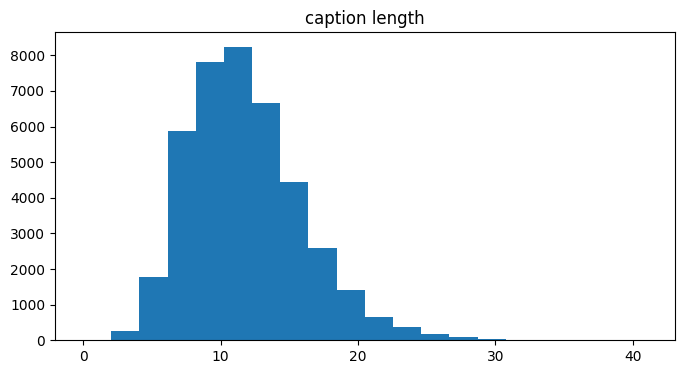

In [9]:
plt.figure(figsize=[8, 4])
plt.title("caption length")
plt.hist(list(map(len, map(str.split, data_inp))), bins=20);

Как выглядит наш датасет? 

In [10]:
captions = pd.read_csv(pjoin(data_path, 'captions.txt')).dropna()
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


35785    A black dachshund sniffs another dog wearing a...
35786    A dog wearing a striped sweater touches noses ...
35787    A white dog wearing a zepra print shirt is nos...
35788    A white dog with a sweater on and a black and ...
35789                      Two dogs meeting nose to nose .
Name: caption, dtype: object


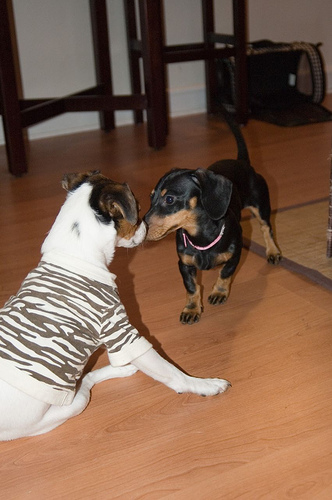

In [11]:
image_file = captions["image"].sample(1).iloc[0]

# выведите все описания для этой картинки
descriptions = captions[captions["image"] == image_file]["caption"]
print(descriptions)

Image.open(pjoin(data_path, "Images", image_file))

In [12]:
image_ids = {k: i for i, k in enumerate(captions["image"].unique())}
image_list = list(map(lambda x: x[0], sorted(image_ids.items(), key=lambda x: x[1])))
captions['image_id'] = captions["image"].map(image_ids)

In [13]:
class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        # Загружаем изображение
        image_path = os.path.join(self.root, self.image_list[item])
        image = Image.open(image_path).convert('RGB')
        
        # Применяем трансформации если они есть
        if self.transform:
            image = self.transform(image)
            
        return image

In [14]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")

True
1
NVIDIA GeForce GTX 1050


In [15]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [16]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn

# с предобученными весами на наборе данных 
# eval : отключаются дропаут (dropout) и нормализация (batch normalization)
cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)
# замена последнего слоя классификации модели на слой Identity. 
# Это означает, что выходные данные модели будут представлять собой извлеченные признаки изображения, а не классы объектов. 
# Таким образом, модель будет использоваться как экстрактор признаков, а не для классификации.
cnn_model.classifier = nn.Identity()

In [17]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root=pjoin(data_path, "Images"), image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, shuffle=False, batch_size=4)

In [18]:
dataset[0]

tensor([[[-0.8909, -0.9708, -1.1183,  ..., -0.6517, -0.2522, -0.2797],
         [-0.9908, -1.0041, -1.1852,  ..., -1.5873, -0.6089, -0.7259],
         [-0.9365, -1.0285, -1.1409,  ..., -1.3691, -1.5218, -1.5402],
         ...,
         [-1.7752, -1.8896, -1.8116,  ..., -1.5529, -1.5319, -1.5923],
         [-1.8131, -1.9113, -1.8382,  ..., -1.6336, -1.7210, -1.7607],
         [-1.6474, -1.7499, -1.8135,  ..., -1.5026, -1.4218, -1.3926]],

        [[-0.8589, -1.0493, -1.2748,  ...,  0.3493,  0.6078,  0.5502],
         [-0.8456, -0.8311, -1.1036,  ..., -1.0335,  0.3240, -0.0600],
         [-0.8063, -0.8612, -1.1217,  ..., -0.9148, -1.0818, -1.2569],
         ...,
         [-1.7751, -1.8032, -1.7415,  ..., -1.6390, -1.6206, -1.6585],
         [-1.7834, -1.8143, -1.7842,  ..., -1.6999, -1.7339, -1.7450],
         [-1.5516, -1.5996, -1.7447,  ..., -1.5882, -1.5364, -1.5122]],

        [[-0.8652, -1.1104, -1.4559,  ..., -1.0578, -0.8068, -0.7909],
         [-0.9346, -0.9347, -1.2672,  ..., -1

In [19]:
#%pip install tqdm==4.65.0

In [20]:
image_embeds = []

with torch.no_grad():
    for images in tqdm(dataloader):
        embeds = cnn_model(images.to(device))
        image_embeds += [embeds.cpu()]

image_embeds = torch.cat(image_embeds, dim=0)

  0%|          | 0/2023 [00:00<?, ?it/s]

Протестируем результат

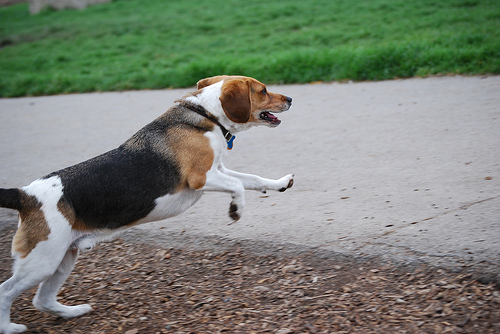

In [22]:
i = 1001
image = Image.open(pjoin(data_path, "Images", image_list[i])).convert('RGB')
image

In [24]:
cnn_model(transform(image).to(device).unsqueeze(0))

tensor([[0.4531, 0.2242, 0.9748,  ..., 0.8778, 0.0575, 0.7846]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [25]:
image_embeds[i]

tensor([0.4531, 0.2242, 0.9748,  ..., 0.8778, 0.0575, 0.7846])

In [26]:
captions[captions.image_id == 1001]

,image,caption,image_id
5005,2099323664_bb20457f26.jpg,a dog jumps onto the sidewalk .,1001
5006,2099323664_bb20457f26.jpg,A small dog runs from the dirt onto the street,1001
5007,2099323664_bb20457f26.jpg,"A tan , white , and black dog runs towards a s...",1001
5008,2099323664_bb20457f26.jpg,Dog leaps out .,1001
5009,2099323664_bb20457f26.jpg,The brown and white dog is standing on its hin...,1001


Итак, у нас все готово для создания тренировочного датасета: вхожные изображения, эмбеддинги и описания. При этом несколько описаний могут использоваться для одного изображения, поэтому будем делить датасет именно по описаниям.

In [27]:
from sklearn.model_selection import train_test_split

train_images, test_images = train_test_split(image_list, test_size=0.2, random_state=42)
train_embeds = image_embeds[[image_list.index(img) for img in train_images]]
test_embeds = image_embeds[[image_list.index(img) for img in test_images]]

train_embeds.shape, test_embeds.shape

(torch.Size([6472, 1280]), torch.Size([1619, 1280]))

In [28]:
train_captions = captions[captions["image"].isin(train_images)]
test_captions = captions[captions["image"].isin(test_images)]

train_captions.shape, test_captions.shape

((32360, 3), (8095, 3))

In [29]:
class CaptionsDataset(Dataset):
    def __init__(self, captions, embeds, images, max_len=64):
        super().__init__()
        self.captions = captions.reset_index()
        self.images = images
        self.embeds = embeds

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, item):
        image_id = self.captions.loc[item, "image_id"]
        return { "x": self.embeds[image_id], "y": self.captions.loc[item, "caption"]}

В этот раз мы попробуем написать свою кастомную функцию склейки в батч с использованием словаря. Она берет элементы батча (список словарей)) и должна объединить x и y в тензоры

In [30]:
def rnn_collate_fn(batch):
    x = torch.stack([item["x"] for item in batch])
    #y = [item["y"] for item in batch]
    y = voc.to_matrix([item["y"] for item in batch])
    return {
        "x": x,
        "y": y
    }

Теперь ее достаточно передать в даталоадер при инициализации

In [31]:
train_set = CaptionsDataset(train_captions, image_embeds, image_list)
test_set = CaptionsDataset(test_captions, image_embeds, image_list)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=rnn_collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=rnn_collate_fn)
embeds_loader = DataLoader(test_embeds, batch_size=128, shuffle=False, collate_fn=rnn_collate_fn)

In [32]:
train_set[0]

{'x': tensor([0.0875, 0.3208, 0.3588,  ..., 0.9939, 0.6720, 2.3017]),
 'y': 'A child in a pink dress is climbing up a set of stairs in an entry way .'}

In [33]:
for batch in train_loader:
    break

In [34]:
batch

{'x': tensor([[0.1286, 0.6452, 0.5041,  ..., 0.3105, 0.1293, 0.7382],
         [1.6647, 0.0201, 0.5245,  ..., 0.0000, 0.0537, 1.2985],
         [0.6548, 0.2443, 0.0220,  ..., 0.1630, 1.1752, 0.0753],
         ...,
         [0.4311, 0.7464, 0.1257,  ..., 0.4272, 0.6799, 0.0658],
         [2.0784, 0.0567, 0.7177,  ..., 0.0978, 0.6718, 0.2441],
         [0.9053, 0.0349, 0.2638,  ..., 0.2304, 0.2609, 0.5107]]),
 'y': tensor([[   0,    2, 2251,  ...,    1,    1,    1],
         [   0,    2, 2354,  ...,    1,    1,    1],
         [   0,    2,    2,  ...,    1,    1,    1],
         ...,
         [   0,    2, 3456,  ...,    1,    1,    1],
         [   0, 6460, 6955,  ...,    1,    1,    1],
         [   0,    2, 2492,  ...,    1,    1,    1]])}

Теперь займемся моделью. Она должна содержать как энкодер, так и декодер. Энкодер должен преобразовывать входной эмбеддинг в понятное модели начальное состояние (скрытое представление и вход), а декодер должен, начиная с этого состояния, генерировать последовательность. Обратите внимание, что если слоев у LSTM больше одного, то инициализировать мы должны все слои сразу. 

Здесь мы также использоуем слой эмбеддинга, который позволит нам перевести токены в векторы.


In [35]:
class CaptionRNN(nn.Module):
    def __init__(self, image_embed_dim, vocab_size, pad_index=1, eos_index=-1, embed_dim=256, hidden_dim=256, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        # Определение линейных слоев для преобразования эмбеддингов изображений 
        # в начальные скрытые состояния (h0) и состояния ячейки (c0) LSTM.
        self.image_embed_to_h0 = nn.Linear(image_embed_dim, lstm_layers * hidden_dim)
        self.image_embed_to_c0 = nn.Linear(image_embed_dim, lstm_layers * hidden_dim) 

        # ля преобразования токенов в векторы фиксированной размерности (embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=lstm_layers, dropout=dropout)
        
        # для преобразования выходных данных LSTM в вероятности для каждого токена в словаре.
        self.linear = nn.Linear(hidden_dim, vocab_size)

        self.eos_index = eos_index
        self.pad_index = pad_index 

    def forward(self, tokens, image_embeds):
        '''
        B - batch size
        M - lstm layers
        L - sequence length
        I - image embedding dim
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # image_embeds: (B, I)
        B = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)
        c0 = self.image_embed_to_c0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)
        # h0, co: (M, B, H)

        # Convert tokens list to tensor if needed
        if isinstance(tokens, list):
            tokens = torch.tensor(tokens, device=device)
            
        # tokens: (B, L)
        # embeds: (B, L, E)
        embeds = self.embedding(tokens).transpose(0, 1)
        output, (h, c) = self.lstm(embeds, (h0, c0))
        logits = self.linear(output.transpose(0, 1))
        # output: (B, L, H), (h, c): (M, B, H)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        # generate lstm input
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)
        c = self.image_embed_to_c0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)
        # # Обеспечиваем, что тензоры имеют непрерывную память
        h, c = h.contiguous(), c.contiguous()

        # init tokens with <bos>
        tokens = torch.full((B, 1), 2, dtype=torch.long, device=device)
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < 64:
            if ((tokens == self.eos_index).sum(1) > 0).all():
                break

            # process newly obtained token
            embeds = self.embedding(tokens[:, -1:]).transpose(0, 1)
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output.transpose(0, 1))

            # get new tokens from logits
            new_tokens = logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens

In [36]:
model = CaptionRNN(
    image_embeds.shape[1], 
    vocab_size=len(voc), 
    eos_index=voc.eos_ix, 
    pad_index=voc.unk_ix
)
model.to(device)

for batch in train_loader:
    break  

d:\AllProjects\FaceDetector\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [37]:
batch

{'x': tensor([[0.4005, 0.2158, 0.1057,  ..., 0.4412, 0.1239, 0.0630],
         [0.1471, 1.3787, 0.2830,  ..., 0.8943, 0.6664, 0.7062],
         [0.6003, 0.2776, 0.0082,  ..., 1.0907, 0.2401, 1.0278],
         ...,
         [0.2596, 0.5438, 0.2069,  ..., 0.3712, 0.2530, 1.1210],
         [1.3852, 0.4365, 0.2201,  ..., 0.7728, 0.0000, 0.4575],
         [0.0025, 0.0308, 0.2193,  ..., 0.3292, 0.1600, 0.6281]]),
 'y': tensor([[   0,    2, 3456,  ...,    1,    1,    1],
         [   0,    2,    2,  ...,    1,    1,    1],
         [   0,    2,  430,  ...,  591,   16,    1],
         ...,
         [   0,    2, 3456,  ...,    1,    1,    1],
         [   0,    2, 3456,  ..., 6145,   16,    1],
         [   0,    2,    2,  ...,    1,    1,    1]])}

In [38]:
# testing
logits = model(batch["y"].to(device), batch["x"].to(device))  # batch["y"] уже будет тензором

# Для инференса:
tokens = model.inference(batch["x"].to(device))
predictions = voc.to_lines(tokens)

In [39]:
logits.shape

torch.Size([128, 23, 6995])

In [40]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np


BLEU_FREQ = 5


def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Напишем трейн луп. Он похож на то, что мы делали раньше, однако мы не используем пакинг. Допольнительное задание: напишите лосс функцию для нашей задачи вручную.

Для оценки модели мы попробуем использовать BLEU.Эта метрика была создана для машинного перевода, но может использоваться и длядругих приложений. Эта метрика просто вычисляет, какая часть предсказанных n-грамм действительно присутствует в эталонном переводе. Он делает это для n=1,2,3 и 4 и вычисляет среднее геометрическое со штрафом, если перевод короче эталонного.

Хотя BLEU имеет множество недостатков, он по-прежнему остается наиболее часто используемой метрикой и одной из самых простых для расчета.

In [41]:
from torchmetrics import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for batch in tqdm(train_loader, desc=tqdm_desc):
        optimizer.zero_grad()
        embeds, captions = batch['x'].to(device), batch['y'].to(device)
        
        # Исправлено: передаем оба аргумента в модель
        logits = model(captions, embeds)  # передаем captions и embeds
        
        # Сдвигаем целевые значения на 1 позицию влево, так как нам нужно предсказывать следующий токен
        targets = captions[:, 1:]  # убираем первый токен (BOS)
        logits = logits[:, :-1, :]  # убираем предсказание после последнего токена
        
        loss = criterion(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for batch in tqdm(valid_loader, desc=tqdm_desc):
        embeds, captions = batch['x'].to(device), batch['y'].to(device)
        
        # Исправлено: передаем оба аргумента в модель
        logits = model(captions, embeds)
        
        # Сдвигаем целевые значения аналогично training_epoch
        targets = captions[:, 1:]
        logits = logits[:, :-1, :]
        
        loss = criterion(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
        
        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


@torch.no_grad()
def evaluate_bleu(model, embeds_loader):
    bleu = BLEUScore()
    all_preds, all_targets = [], []
    for batch in embeds_loader:
        embeds, captions = batch['x'].to(device), batch['y']
        
        tokens = model.inference(embeds.to(device))
        # Преобразуем предсказания в текст
        preds = voc.to_lines(tokens.cpu())
        all_preds.extend(preds)
        all_targets.extend([voc.to_lines([caption]) for caption in captions])
    return bleu(all_preds, all_targets).item()


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, log_frequency=1):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % log_frequency == 0:
            valid_bleu = evaluate_bleu(model, valid_loader)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [42]:
NUM_EPOCHS = 200

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=voc.unk_ix)

sum(param.numel() for param in model.parameters())

4770643

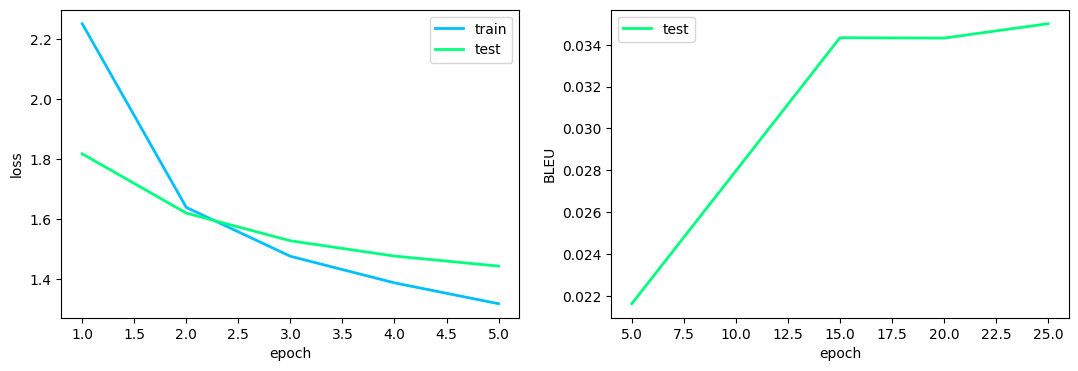

In [43]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, 5)

Также посмотрим на случайную картинку из нашего набора.

In [44]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(image_embeds[index].unsqueeze(0).to(device))
    prediction = voc.to_lines(tokens)
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions["image"] == image_file].caption):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(pjoin(data_path, 'Images', image_file)).convert('RGB')

Prediction: ['_UNK_ a man is climbing a rock face .']
GT caption #1: A girl jumps from an orange raft into a lake .
GT caption #2: a girl jumps off of a raft .
GT caption #3: Girl jumping into water from a raft .
GT caption #4: Girl jumping off a raft into a lake .
GT caption #5: The young girl is airborne as she falls into the lake .


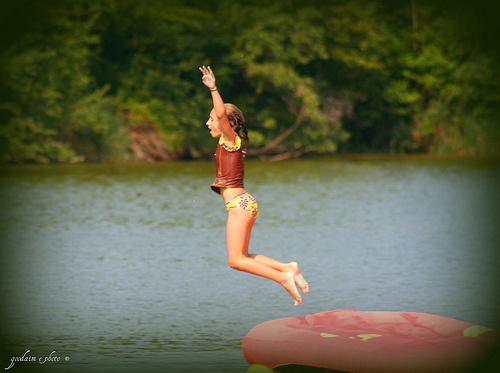

In [45]:
caption_random_test_image()

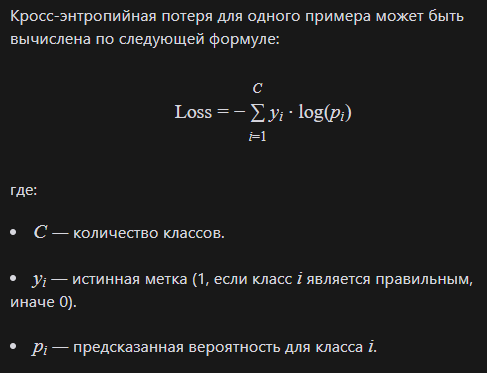

In [54]:
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index=-1):
        super(CustomCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Применяем softmax к входным данным
        # softmax преобразует входные данные в вероятности, которые суммируются до 1
        log_probs = torch.log_softmax(inputs, dim=-1)
        
        # Получаем маску для игнорируемых индексов
        mask = (targets != self.ignore_index).float()
        
        # Вычисляем потери
        # Делит общую сумму потерь на количество элементов, которые не были замаскированы 
        # (т.е. на количество токенов, которые мы действительно учитываем в расчете потерь). 
        # Это позволяет нормализовать потери по количеству действительных токенов.
        losses = -torch.sum(mask * log_probs[range(targets.size(0)), targets]) / torch.sum(mask)
        return losses

criterion = CustomCrossEntropyLoss(ignore_index=voc.unk_ix)

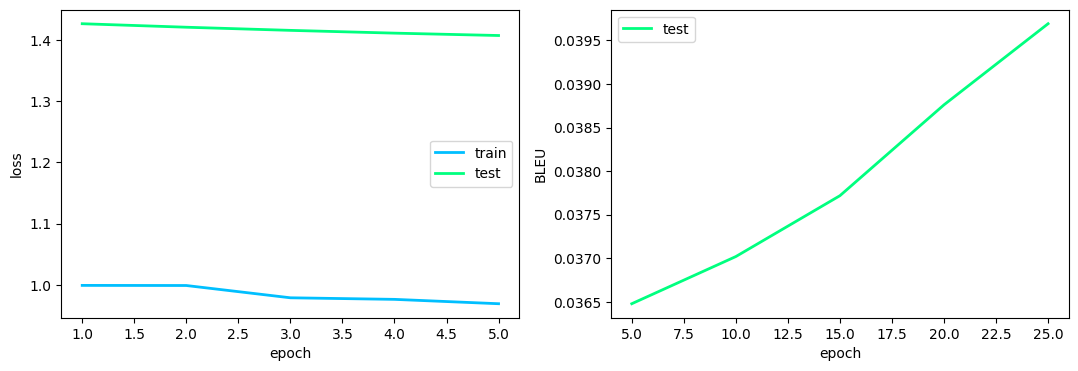

In [55]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, 5)

Prediction: ['_UNK_ a boy in a blue shirt is sitting on a rock in the grass .']
GT caption #1: A coach speaking to a football player while everyone watches .
GT caption #2: A football player from OU talks to the coach about the game .
GT caption #3: A football player is talking to his coach .
GT caption #4: The coaching official and football player are talking in front a crowd and other team members .
GT caption #5: The coach talks it over with his quarterback during a timeout .


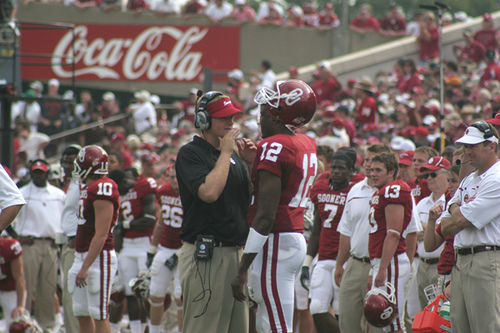

In [57]:
caption_random_test_image()

Что дальше? 

- Вы можете использовать механизм внимания, чтобы модель была лучше интерпреируема и была качественней.
Как это работает: https://distill.pub/2016/augmented-rnns/
Один из способов сделать это: https://arxiv.org/abs/1502.03044.
- Можно перейти на трансформеры

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class ImageCaptioningTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(ImageCaptioningTransformer, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.dropout = dropout
        
        # Эмбеддинг для текстовых токенов
        self.token_embedding = nn.Embedding(self.input_dim, self.embed_dim)
        
        # Проекция эмбеддингов изображения в нужную размерность
        self.image_projection = nn.Linear(1280, self.embed_dim)  # 1280 - размерность эмбеддингов MobileNetV2
        
        # Позиционное кодирование
        # позиционную информацию к эмбеддингам токенов в модели трансформера. 
        # Поскольку трансформеры не имеют встроенной информации о порядке токенов 
        # (в отличие от рекуррентных нейронных сетей), 
        # позиционное кодирование позволяет модели учитывать порядок слов в последовательности.
        self.pos_encoder = PositionalEncoding(self.embed_dim, self.dropout)
        
        # Слой для self-attention текстовых токенов
        # позволяет модели обращать внимание на разные части входной последовательности 
        # (текстовых токенов) при генерации выходных данных.
        self.self_attention = nn.MultiheadAttention(self.embed_dim, self.num_heads, dropout=self.dropout)
        
        # Слой для cross-attention между текстом и изображением
        # позволяет модели учитывать как текстовые токены, так и эмбеддинги изображений.
        self.cross_attention = nn.MultiheadAttention(self.embed_dim, self.num_heads, dropout=self.dropout)
        
        # Feed-forward слои
        self.feed_forward = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim * 4),
            # заменяет все отрицательные значения на ноль
            # Это помогает модели учиться быстрее и уменьшает вероятность исчезновения градиента.
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.embed_dim * 4, self.embed_dim)
        )
        
        # Нормализация
        # считаем статистики тольк по размерностям эмбеддинга в отличие от batchnorm
        self.norm1 = nn.LayerNorm(self.embed_dim)
        self.norm2 = nn.LayerNorm(self.embed_dim)
        self.norm3 = nn.LayerNorm(self.embed_dim)
        
        # Выходной слой
        self.fc_out = nn.Linear(self.embed_dim, self.output_dim)
        
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, text_tokens, image_features):
        # text_tokens: [batch_size, seq_len]
        # image_features: [batch_size, 1280]
        
        # Эмбеддинг текстовых токенов
        text_embed = self.token_embedding(text_tokens)  # [batch_size, seq_len, embed_dim]                          # * math.sqrt(self.embed_dim)
        text_embed = self.pos_encoder(text_embed)
        # Меняет порядок размерностей тензора, чтобы он соответствовал ожидаемому 
        # формату для слоя внимания, где первая размерность — 
        # это длина последовательности (количество токенов).
        text_embed = text_embed.transpose(0, 1)  # [seq_len, batch_size, embed_dim]
        
        # Проекция изображения
        image_embed = self.image_projection(image_features).unsqueeze(0)  # [1, batch_size, embed_dim]
        
        # Self-attention для текста
        text_attend, _ = self.self_attention(
            text_embed, text_embed, text_embed,
            # для предотвращения внимания к будущим токенам,
            attn_mask=self.generate_square_subsequent_mask(text_embed.size(0)).to(text_tokens.device)
        )
        text_embed = self.norm1(text_embed + self.dropout(text_attend))
        
        # Cross-attention между текстом и изображением
        # помогает модели интегрировать информацию из изображений в процесс генерации текста
        cross_attend, _ = self.cross_attention(
            text_embed, image_embed, image_embed
        )
        text_embed = self.norm2(text_embed + self.dropout(cross_attend))
        
        # Feed-forward
        # Применяет полносвязные слои к выходам из слоя внимания. 
        # Это позволяет модели обрабатывать информацию более глубоко и извлекать сложные зависимости.
        ff_output = self.feed_forward(text_embed)
        text_embed = self.norm3(text_embed + self.dropout(ff_output))
        
        # Выходной слой
        # Преобразует финальные эмбеддинги в вероятности для каждого токена в словаре. 
        # Транспонирование возвращает тензор в формат [batch_size, seq_len, vocab_size], 
        # что позволяет интерпретировать выходы как вероятности для каждого токена в последовательности.
        output = self.fc_out(text_embed.transpose(0, 1))  # [batch_size, seq_len, vocab_size]
        
        return output

    def generate_square_subsequent_mask(self, sz):
        "нижняя треугольная матрица заполненная нулями"
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def inference(self, image_features, max_len=20, start_token=0):
        self.eval()
        with torch.no_grad():
            text_tokens = torch.full((1, 1), start_token, dtype=torch.long, device=device)
            for _ in range(max_len):
                output = self.forward(text_tokens, image_features)
                next_token = output.argmax(-1)[:, -1].unsqueeze(0)
                text_tokens = torch.cat((text_tokens, next_token), dim=1)
                if next_token.item() == 1:  # Предполагаем, что 1 - это токен конца предложения (EOS)
                    break
        return text_tokens.squeeze().tolist()


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [45]:
# Инициализация модели
input_dim = len(voc)  # размер словаря
embed_dim = 512  # размерность эмбеддингов
num_heads = 8  # количество голов внимания
num_layers = 6  # количество слоев
output_dim = len(voc)  # размер словаря

model = ImageCaptioningTransformer(
    input_dim=input_dim,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=voc.unk_ix)

In [48]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [49]:
def train_image_captioning(model, optimizer, criterion, train_loader, num_epochs):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in train_loader:
            text_tokens = batch['y'].to(device)
            image_features = batch['x'].to(device)
            
            optimizer.zero_grad()
            
            output = model(text_tokens, image_features)
            
            # Сдвигаем целевые значения на 1 позицию влево
            targets = text_tokens[:, 1:]  # убираем первый токен (BOS)
            output = output[:, :-1, :]  # убираем предсказание после последнего токена
            
            loss = criterion(output.reshape(-1, output.shape[-1]), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss}')
    
        plot_losses(train_losses)

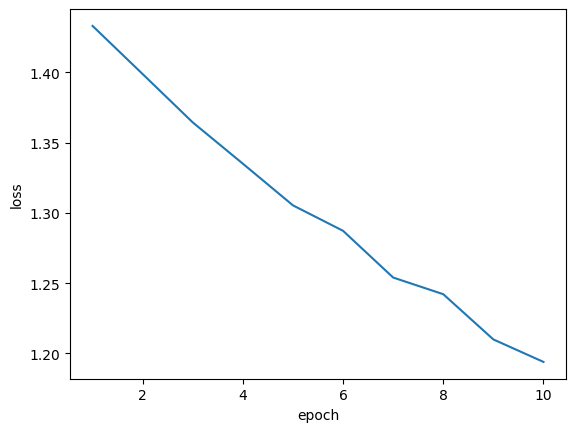

In [63]:
train_image_captioning(model, optimizer, criterion, train_loader, 10)

In [51]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    image_features = image_embeds[index].unsqueeze(0).to(device)
    tokens = model.inference(image_features)
    prediction = voc.to_lines(np.array(tokens).reshape(1, -1))
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions["image"] == image_file].caption):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(pjoin(data_path, 'Images', image_file)).convert('RGB')

Prediction: ['a boy wearing a red shirt and a green shirt is standing in front of a park .']
GT caption #1: A girl has her head in a wooden cut out of a pirate ship while people throw tomatos .
GT caption #2: A little girl throws an object at a man who is standing behind a cutout of a sailor on a ship .
GT caption #3: A young boy and girl are trying to hit a man with balls in a fair game .
GT caption #4: Children are throwing food at someone as part of an amusement park game .
GT caption #5: Children watching a play .


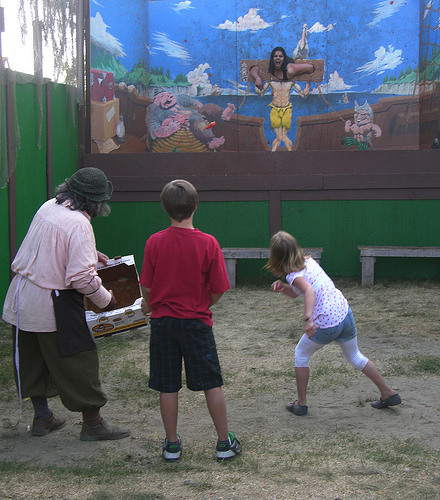

In [70]:
caption_random_test_image()

Prediction: ['a woman in a black shirt and a red shirt is standing on a bench .']
GT caption #1: One man in the hole of a tire in water , and another man getting up from the water next to him .
GT caption #2: Two boys hanging off a tire dock .
GT caption #3: Two men are playing with tires in muddy water .
GT caption #4: Two men climb onto tires while sitting in the muddy water .
GT caption #5: Two men trying to hoist themselves up from the water on to a walkway made of tires .


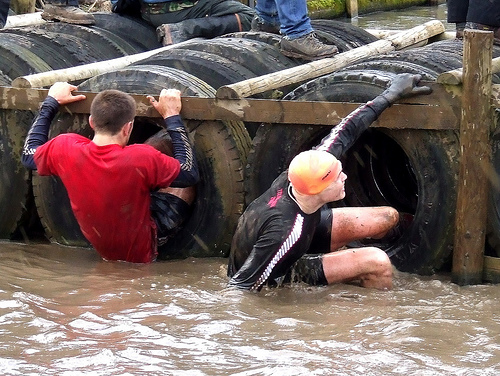

In [57]:
caption_random_test_image()

Prediction: ['a black dog is running through a large stick in a grassy area .']
GT caption #1: A dog leaps over a barrier .
GT caption #2: A dog leaps over a fence .
GT caption #3: A dog leaps over a wooden fence as another is about to .
GT caption #4: There are two dogs ; one leaps over the fence and the other tries to .
GT caption #5: Two brown and black dogs are jumping a fence .


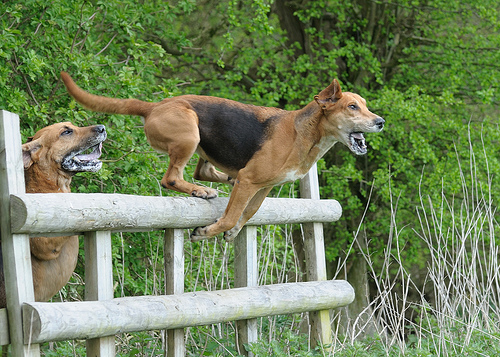

In [78]:
caption_random_test_image()